### Nama : Eva Fadhillah Ulia
### NIM  : A11.2022.14283

### PROJECT UAS KOMPUTASI KUANTUM 

## Import dan Setup Awal

In [61]:
import qiskit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


In [62]:
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from qiskit.utils import algorithm_globals
from sklearn.preprocessing import StandardScaler

Keterangan : 
data.data: berisi fitur-fitur numerik (X)
data.target: berisi label klasifikasi (y) → 0 = malignant, 1 = benign
data.feature_names: nama-nama kolom

In [63]:
data = load_breast_cancer()

In [64]:
# Convert ke DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# Cek isi data
print(df.head())

   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0             

In [65]:
x = data.data
y = data.target

In [66]:
x = MinMaxScaler().fit_transform(x)

In [67]:
print(x.shape)

(569, 30)


In [68]:

# Jika fitur > 4, lakukan PCA untuk ambil 4 fitur saja
if x.shape[1] > 4:
    pca = PCA(n_components=4)
    x_reduced = pca.fit_transform(x)
else:
    x_reduced = x

# Jika data record > 150, ambil 150 data secara acak
import numpy as np
if x_reduced.shape[0] > 150:
    idx = np.random.choice(x_reduced.shape[0], 150, replace=False)
    x_reduced = x_reduced[idx]
    y = y[idx]

print("Shape fitur setelah PCA / sampling:", x_reduced.shape)  # seharusnya (150, 4)



Shape fitur setelah PCA / sampling: (150, 4)


In [69]:
# Split data train-test (80% train, 20% test)
algorithm_globals.random_seed = 123
train_x, test_x, train_y, test_y = train_test_split(
    x_reduced, y, train_size=0.8, random_state=algorithm_globals.random_seed
)

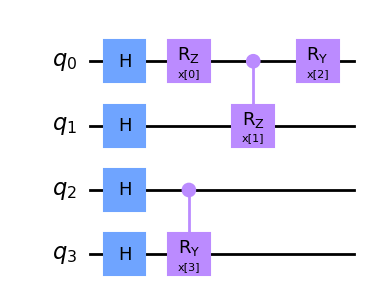

In [70]:
# Definisikan parameter quantum circuit
jum_fitur = x_reduced.shape[1]  # 4 fitur
theta_list = ParameterVector('x', length=jum_fitur)

# Buat quantum circuit dengan 4 qubit
feature_map_1 = QuantumCircuit(jum_fitur)
feature_map_1.h(range(jum_fitur))
feature_map_1.rz(theta_list[0], 0)
feature_map_1.crz(theta_list[1], 0, 1)
feature_map_1.ry(theta_list[2], 0)
feature_map_1.cry(theta_list[3], 2, 3)

# Tampilkan circuit
feature_map_1.draw('mpl')

In [71]:
import qiskit
import os

style_folder = os.path.join(qiskit.__path__[0], "visualization", "circuit", "styles")
print("Folder styles ada?", os.path.exists(style_folder))
print("Isi folder:", os.listdir(style_folder) if os.path.exists(style_folder) else "Folder tidak ada")


Folder styles ada? True
Isi folder: ['bw.json', 'clifford.json', 'textbook.json', 'iqx.json', 'default.json', 'iqx-dark.json']


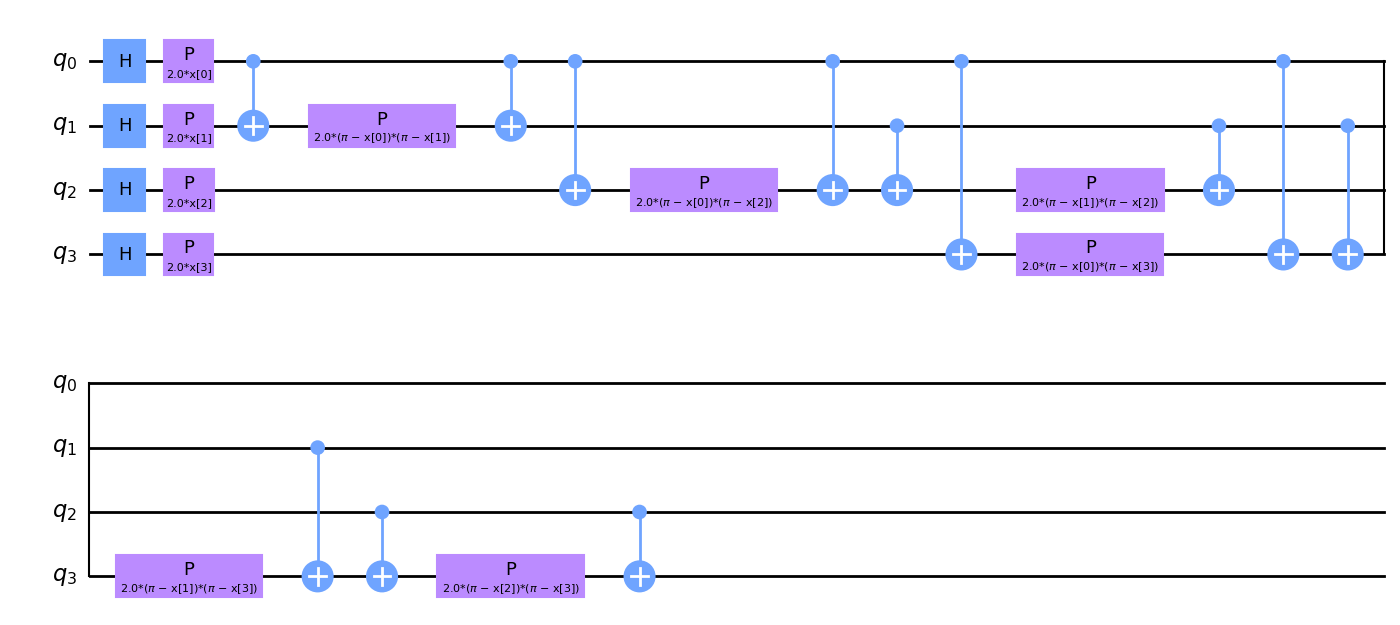

In [73]:
jum_fitur = x_reduced.shape[1]
feature_map = ZZFeatureMap(feature_dimension=jum_fitur, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

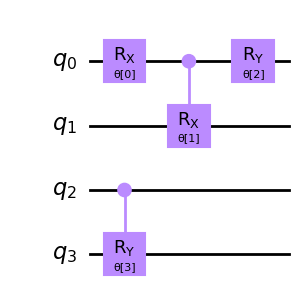

In [74]:
theta_list = ParameterVector('θ', length=jum_fitur)

ansatz_1 = QuantumCircuit(jum_fitur)
ansatz_1.rx(theta_list[0], 0)
ansatz_1.crx(theta_list[1], 0, 1)
ansatz_1.ry(theta_list[2], 0)
ansatz_1.cry(theta_list[3], 2, 3)
ansatz_1.draw('mpl')

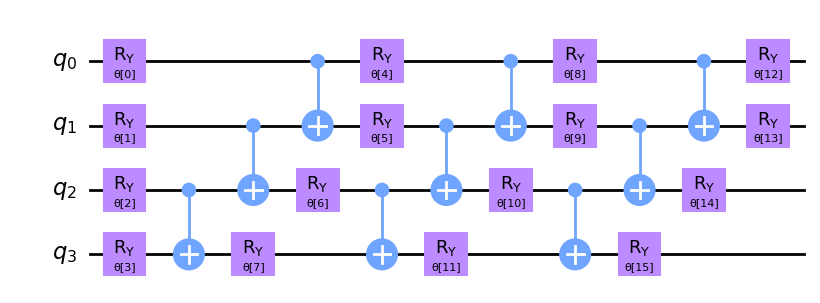

In [75]:
from qiskit.circuit.library import RealAmplitudes

ansatz_2 = RealAmplitudes(num_qubits=jum_fitur, reps=3)
ansatz_2.decompose().draw(output="mpl", style="clifford", fold=20)

In [76]:
from qiskit.algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=10)

In [77]:
from qiskit.primitives import Sampler

sampler = Sampler()


In [78]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Nilai fungsi objektif terhadap iterasi")
    plt.xlabel("Iterasi")
    plt.ylabel("Nilai fungsi objektif")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

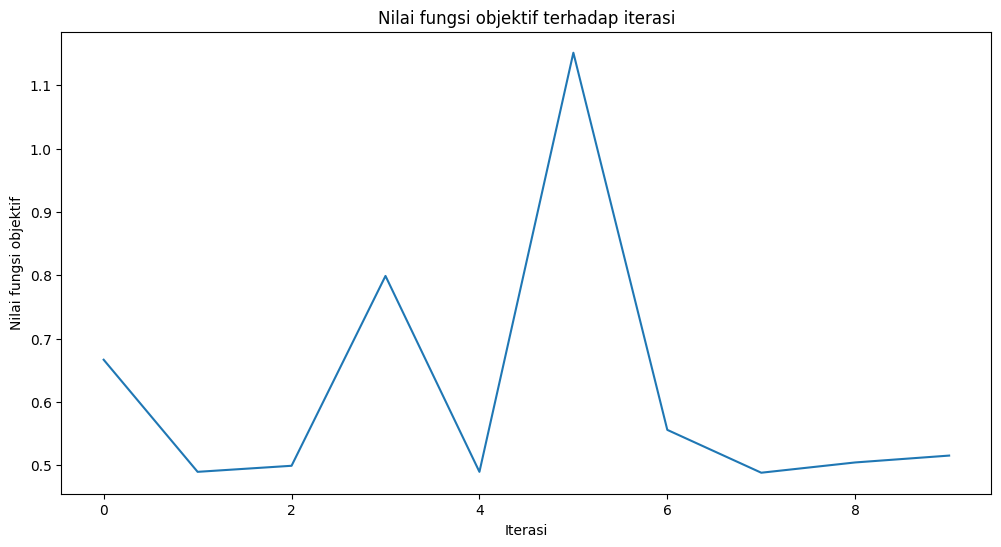

Waktu Training : 1 detik


In [79]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map_1,  # sebagai alternatif: feature_map_2
    ansatz=ansatz_1,            # sebagai alternatif: ansatz_2
    optimizer=optimizer,
    callback=callback_graph,
)

# hapus histori nilai oyektif 
objective_func_vals = []

start = time.time()
vqc.fit(train_x, train_y)
elapsed = time.time() - start

print(f"Waktu Training : {round(elapsed)} detik")

In [80]:
score_pelatihan_1 = vqc.score(train_x, train_y)
score_pengujian_1 = vqc.score(test_x, test_y)

print(f"VQC kuantum pada dataset pelatihan: {score_pelatihan_1:.2f}")
print(f"VQC kuantum pada dataset uji      : {score_pengujian_1:.2f}")

VQC kuantum pada dataset pelatihan: 0.93
VQC kuantum pada dataset uji      : 0.93


<Axes: >

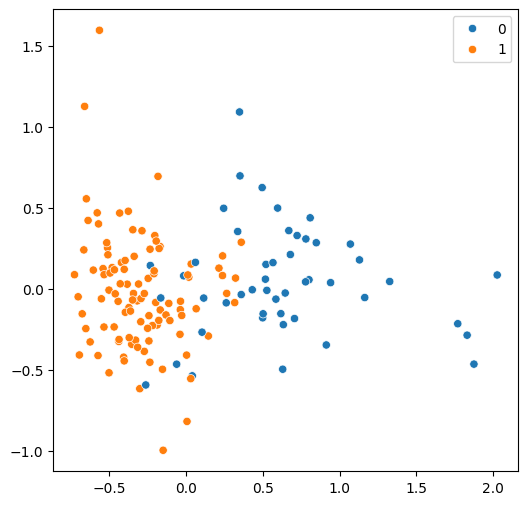

In [81]:
# Tetapkan jumlah fitur sebagai integer
jum_fitur = 2

# Lakukan PCA dengan 2 komponen
pca = PCA(n_components=jum_fitur)
x_PCA = pca.fit_transform(x_reduced)

# Visualisasi
plt.figure(figsize=(6,6))
sns.scatterplot(x=x_PCA[:, 0], y=x_PCA_2d[:, 1], hue=y, palette="tab10")



In [82]:
train_x, test_x, train_y, test_y = train_test_split(
    x_PCA, y, train_size=0.8, random_state=algorithm_globals.random_seed
)

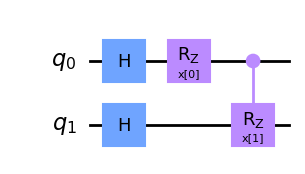

In [83]:
from qiskit.circuit import ParameterVector
from qiskit import QuantumCircuit

theta_list = ParameterVector('x', length=jum_fitur)

feature_map_1 = QuantumCircuit(jum_fitur)
feature_map_1.h([0,1])
feature_map_1.rz(theta_list[0], 0)
feature_map_1.crz(theta_list[1], 0, 1)
feature_map_1.draw('mpl')

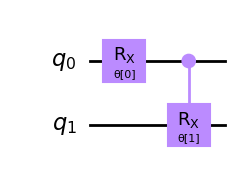

In [84]:
theta_list = ParameterVector('θ', length=jum_fitur)

ansatz_1 = QuantumCircuit(jum_fitur)
ansatz_1.rx(theta_list[0], 0)
ansatz_1.crx(theta_list[1], 0, 1)
ansatz_1.draw('mpl')

In [85]:
feature_map_2 = ZZFeatureMap(feature_dimension=jum_fitur, reps=1)
ansatz_2 = RealAmplitudes(num_qubits=jum_fitur, reps=3)

In [86]:
optimizer = COBYLA(maxiter=10)

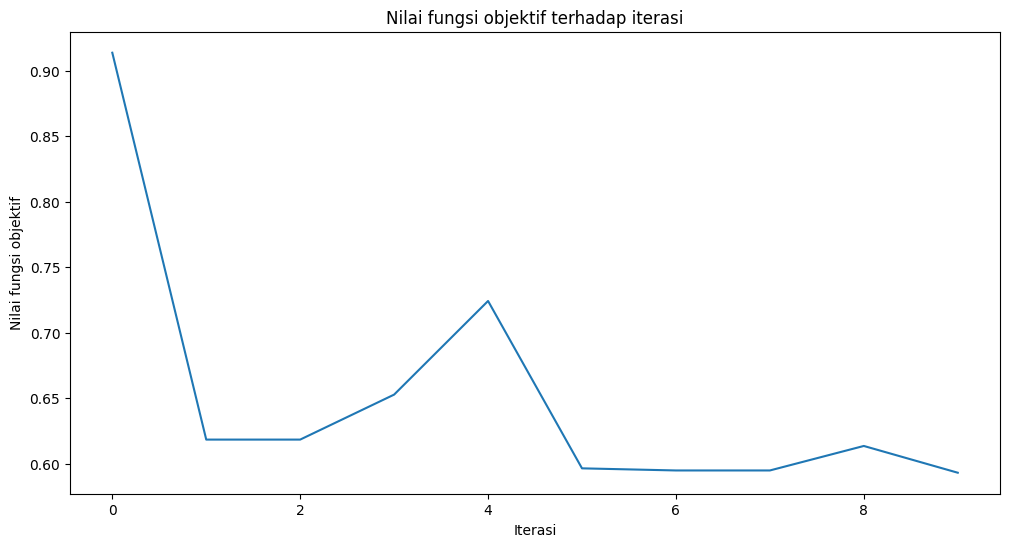

Waktu Training: 1 detik


In [87]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map_1,
    ansatz=ansatz_1,
    optimizer=optimizer,
    callback=callback_graph,
)

# hapus histori nilai obyektif
objective_func_vals = []

# membuat plot fungsi objektif terlihat lebih bagus.
plt.rcParams["figure.figsize"] = (12, 6)


start = time.time()
vqc.fit(train_x, train_y)
elapsed = time.time() - start

print(f"Waktu Training: {round(elapsed)} detik")

In [88]:
score_pelatihan_2 = vqc.score(train_x, train_y)
score_pengujian_2 = vqc.score(test_x, test_y)

print(f"VQC kuantum pada dataset pelatihan menggunakan RealAmplitudes: {score_pelatihan_2:.2f}")
print(f"VQC kuantum pada dataset uji menggunakan RealAmplitudes      : {score_pengujian_2:.2f}")

VQC kuantum pada dataset pelatihan menggunakan RealAmplitudes: 0.88
VQC kuantum pada dataset uji menggunakan RealAmplitudes      : 0.80


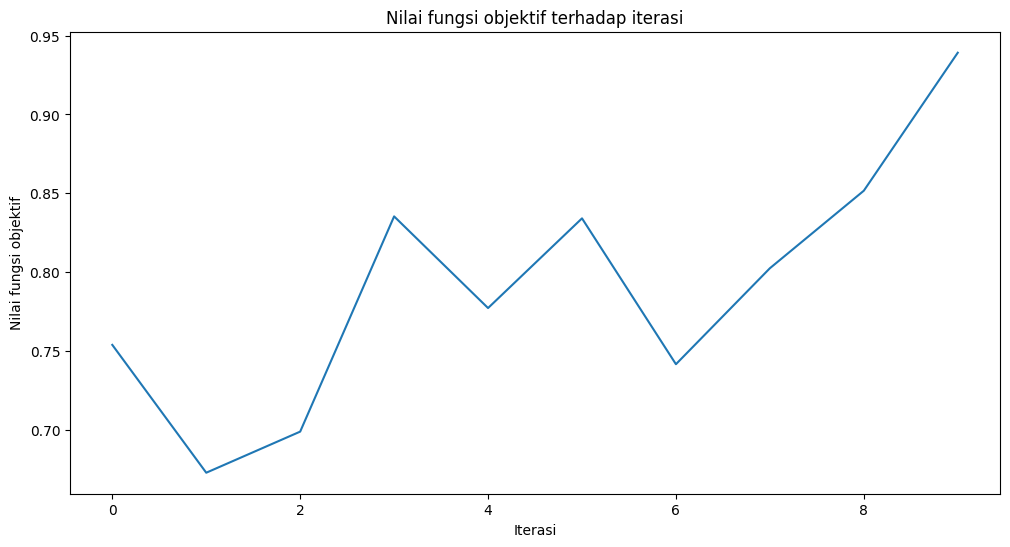

Waktu Training: 2 detik


In [89]:
from qiskit.circuit.library import EfficientSU2

ansatz_2 = EfficientSU2(num_qubits=jum_fitur, reps=3)
optimizer = COBYLA(maxiter=10)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map_1,
    ansatz=ansatz_2,               #  pakai anzats baru
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_x, train_y)
elapsed = time.time() - start

print(f"Waktu Training: {round(elapsed)} detik")

In [90]:
score_pelatihan_3 = vqc.score(train_x, train_y)
score_pengujian_3 = vqc.score(test_x, test_y)

print(f"VQC kuantum pada dataset pelatihan menggunakan EfficientSU2: {score_pelatihan_3:.2f}")
print(f"VQC kuantum pada dataset uji menggunakan EfficientSU2      : {score_pengujian_3:.2f}")

VQC kuantum pada dataset pelatihan menggunakan EfficientSU2: 0.89
VQC kuantum pada dataset uji menggunakan EfficientSU2      : 0.90


In [91]:
print(f"Model                     | Score Pelatihan | Score Pengujian")
print(f"VQC, 4 features, Anzats_1 | {score_pelatihan_1:10.2f} | {score_pengujian_1:10.2f}")
print(f"VQC, 2 features, Anzats_1 | {score_pelatihan_2:10.2f} | {score_pengujian_2:10.2f}")
print(f"VQC, 2 features, Anzats_2 | {score_pelatihan_3:10.2f} | {score_pengujian_3:10.2f}")

Model                     | Score Pelatihan | Score Pengujian
VQC, 4 features, Anzats_1 |       0.93 |       0.93
VQC, 2 features, Anzats_1 |       0.88 |       0.80
VQC, 2 features, Anzats_2 |       0.89 |       0.90


In [92]:
import qiskit
print(qiskit.__qiskit_version__)

{'qiskit-terra': '0.22.4', 'qiskit-aer': '0.11.2', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.39.5', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': '0.6.1'}
